# Disaster recognition from tweets with deep learning

The aim of this project is to create and train a recurrent neural network to recognize disasters from tweets, with high accuracy. The GitHub repository for the project is the following: https://github.com/mohosb/disaster_tweets

The data is from the Kaggle competition "Natural Language Processing with Disaster Tweets" (https://www.kaggle.com/competitions/nlp-getting-started/overview).

In this project I will use PyTorch, a popular deep learning library for Python, and also a package called "nn_utils", that contains lots of useful functions. This package is writen and developed entirely by me. (https://github.com/szegedai/nn_utils)

In [ ]:
import torch
import pandas as pd
from nn_utils.misc import split_dataset, create_data_loaders
from nn_utils.training import train_classifier, CLILoggerCallback

## EDA

In the following cells, we can see that there are 5 columns and 7613 rows. There is a significant amount of missing values in columns "keyword" and "location". Because of this, it may be beneficial to not use those columns and just simply use the text.

There are two possible labels, 0 and 1. These represent if the tweet is about a disaster or not. The balance between the two labels is not ideal, but it is good enough to used reliably in my opinion.

In [106]:
df = pd.read_csv('./train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


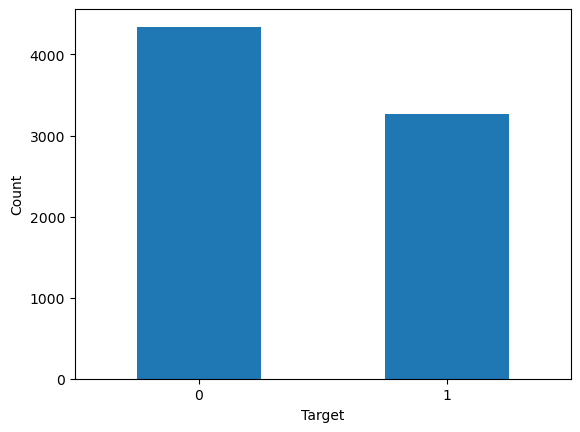

In [113]:
df['target'].value_counts().plot(kind='bar', xlabel='Target', ylabel='Count', rot=0);

## Data loading, preprocessing and cleaning

In this section we will be doing the following:
- Load the raw text data
- Remove some characters to simplify the task
- Break the texts into words/tokens
- Build a vocabulary that can be used to create a basic number representation from tokens

In [ ]:
class Vocab:
    def __init__(self, tokens):
        unique_tokens = set(tokens)
        self.forward_mapping = dict(zip(unique_tokens, range(1, len(unique_tokens) + 1)))
        self.backward_mapping = dict(zip(range(1, len(unique_tokens) + 1), unique_tokens))

    def extend(self, tokens):
        start_idx = len(self.forward_mapping)
        for i, t in enumerate(tokens):
            self.forward_mapping[t] = start_idx + i + 1
            self.backward_mapping[start_idx + i + 1] = t

    def token2idx(self, tokens):
        return [self.forward_mapping.get(token, 0) for token in tokens]

    def idx2token(self, idxs):
        return [self.backward_mapping.get(idx, '<OOV>') for idx in idxs]

    def __len__(self):
        return len(self.forward_mapping) + 1

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, path, preprocessor=None, with_labels=True):
        super().__init__()
        self.df = pd.read_csv(path, usecols=['text', 'target'] if with_labels else ['text'])
        if preprocessor is not None:
            self.df['text'] = self.df['text'].map(preprocessor)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return tuple(self.df.iloc[idx].values)

In [ ]:
def clean_text(t):
    for c in [',', ':', '.', '!', '?', '#', '@', '\'', '\"']:
        t = t.replace(c, '')
    t = t.replace('\n', ' ')
    return t.lower()

train_ds, val_ds = split_dataset(TweetDataset('./train.csv', clean_text, with_labels=True), split=0.1, seed=42)
test_ds = TweetDataset('./test.csv', clean_text, with_labels=False)
train_loader, val_loader = create_data_loaders(
    [train_ds, val_ds],
    batch_size=256, shuffle=True,
    num_workers=0, multiprocessing_context=None, persistent_workers=False
)
test_loader, = create_data_loaders(
    [test_ds], batch_size=256, shuffle=False,
    num_workers=0, multiprocessing_context=None, persistent_workers=False
)

tokens = set()
for t, _ in iter(train_ds):
    tokens.update(t.split(' '))
vocab = Vocab(tokens)

In [ ]:
test_text = \
'''This is a simple text to test the tokenization.
By the way, all dogs are cute! :D'''
vocab.token2idx(clean_text(test_text).split(' '))

## Model building

In the following section we will attempt to build two basic RNN architectures for the classification task. Both will use an embedding layer to transform the basic index based numerical representation of the vocabulary into a higher dimensional representation that is more descriptive of the actual tokens and can be much more useful for the neural network to work with. The embedded vectors will be ran through an LSTM in the first model architecture and a GRU in the case of the other model. The output of the LSTM or GRU will be fed to a simple fully connected layer to make the final classification.

In [ ]:
class GRUClassifier(torch.nn.Module):
    def __init__(self, preprocessor, vocab, num_classes, embedding_dim, width, dropout=0.0):
        super().__init__()
        self.preprocessor = preprocessor
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(len(self.vocab), embedding_dim)
        self.gru = torch.nn.GRU(embedding_dim, hidden_size=width, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(width, num_classes)

        self.device = 'cpu'
        self.dtype = torch.float32

    def forward(self, text):
        tokens = map(lambda t: self.vocab.token2idx(self.preprocessor(t).split(' ')), text)
        logits = []
        for x in tokens:
            x = torch.tensor(x, device=self.device, dtype=torch.int64)[None, :]
            x = self.embedding(x)
            _, x = self.gru(x)
            x = self.dropout(x)
            x = self.classifier(x[0])
            logits.append(x)
        return torch.concat(logits, dim=0)

    def to(self, device, dtype=None, **kwargs):
        self.device = device
        if dtype:
            self.dtype = dtype
        return super().to(device=self.device, dtype=self.dtype, **kwargs)

In [ ]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self, preprocessor, vocab, num_classes, embedding_dim, width, dropout=0.0):
        super().__init__()
        self.preprocessor = preprocessor
        self.vocab = vocab
        self.embedding = torch.nn.Embedding(len(self.vocab), embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_size=width, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(width, num_classes)

        self.device = 'cpu'
        self.dtype = torch.float32

    def forward(self, text):
        tokens = map(lambda t: self.vocab.token2idx(self.preprocessor(t).split(' ')), text)
        logits = []
        for x in tokens:
            x = torch.tensor(x, device=self.device, dtype=torch.int64)[None, :]
            x = self.embedding(x)
            _, (x, _) = self.lstm(x)
            x = self.dropout(x)
            x = self.classifier(x[0])
            logits.append(x)
        return torch.concat(logits, dim=0)

    def to(self, device, dtype=None, **kwargs):
        self.device = device
        if dtype:
            self.dtype = dtype
        return super().to(device=self.device, dtype=self.dtype, **kwargs)

## Model training any hyperparameter tuning

We can play a bit with the different hyperparameters that are learning rate, weight decay, embedding dimension size and hidden layer size. In an ideal situation it is advised to run a full hyperparameter search like a grid search but at this moment I do not have the computational resources to do this, so I will just try a few configurations with a fairly heuristic approach.

In [ ]:
# Uncomment the device you would like to use!
device = torch.device('cpu')
#device = torch.device('mps')
#device = torch.device('cuda')

# Uncomment the model you would like to use!
#model = LSTMClassifier(clean_text, vocab, num_classes=2, embedding_dim=64, width=128).to(device)
#model = GRUClassifier(clean_text, vocab, num_classes=2, embedding_dim=64, width=256).to(device)
#model = GRUClassifier(clean_text, vocab, num_classes=2, embedding_dim=128, width=128).to(device)
#model = GRUClassifier(clean_text, vocab, num_classes=2, embedding_dim=256, width=128).to(device)
model = GRUClassifier(clean_text, vocab, num_classes=2, embedding_dim=576, width=128).to(device)
#model = GRUClassifier(clean_text, vocab, num_classes=2, embedding_dim=1024, width=256).to(device)

# Uncomment the optimizer you would like to use!
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

train_classifier(model, loss_fn, optimizer, train_loader, val_loader,
                 callbacks=[
                     CLILoggerCallback()
                 ], num_epochs=1)

## Results and conclusion

| model type | learning rate | weight decay | embedding dimension | hidden layers width | number of epochs | validation accuracy |
|------------|---------------|--------------|---------------------|---------------------|------------------|---------------------|
| lstm       | 0.001         | 0.0001       | 64                  | 128                 | 3                | 66.23%              |
| gru        | 0.001         | 0.0001       | 64                  | 128                 | 3                | 70.04%              |
| gru        | 0.001         | 0.0001       | 64                  | 256                 | 3                | 65.57%              |
| gru        | 0.001         | 0.001        | 64                  | 256                 | 3                | 66.10%              |
| gru        | 0.001         | 0.001        | 64                  | 128                 | 3                | 70.83%              |
| gru        | 0.001         | 0.001        | 128                 | 128                 | 3                | 71.35%              |
| gru        | 0.001         | 0.005        | 128                 | 128                 | 3                | 72.54%              |
| gru        | 0.001         | 0.01         | 128                 | 128                 | 3                | 69.78%              |
| gru        | 0.001         | 0.01         | 256                 | 128                 | 3                | 73.32%              |
| gru        | 0.001         | 0.01         | 512                 | 128                 | 3                | 74.90%              |
| gru        | 0.01          | 0.01         | 512                 | 128                 | 1                | 77.79%              |
(Rerunning the trainings may not produce the exact same results because of the random nature of the network initialization.)

Overfitting was the biggest problem during the trainings. First off, LSTM showed much more overfitting by default which is not to surprising since it is a bit of an overcomplicated architecture. Because of this I chose to use GRU for every other test. Despite this, ovefitting remained a big trouble. Increasing the number of neurons in the hidden layers, significantly increases the training accuracy, but the at the same time, decreases the validation accuracy, this is why I chose to keep the 128. To combat the overfitting, I started to increase the weight decay and the embedding dimension size. After that, I noticed that the first epoch always has the best validation accuracy, so for my last training I used only 1 epoch.

In conclusion, the model was improved significantly by just playing with the hyperparameters, but I am sure that a much better configuration could be found with the appropriate amount of hyperparameters searching.

In [ ]:
all_ids = pd.read_csv('./test.csv', usecols=['id']).values[:, 0]
all_predictions = []
model.eval()
for text, in test_loader:
    all_predictions += model(text).argmax(dim=1).to(dtype=torch.int).tolist()
submission = pd.DataFrame({'id': all_ids, 'target': all_predictions})
submission.to_csv('submission.csv', sep=',', header=True, index=False)